<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done.


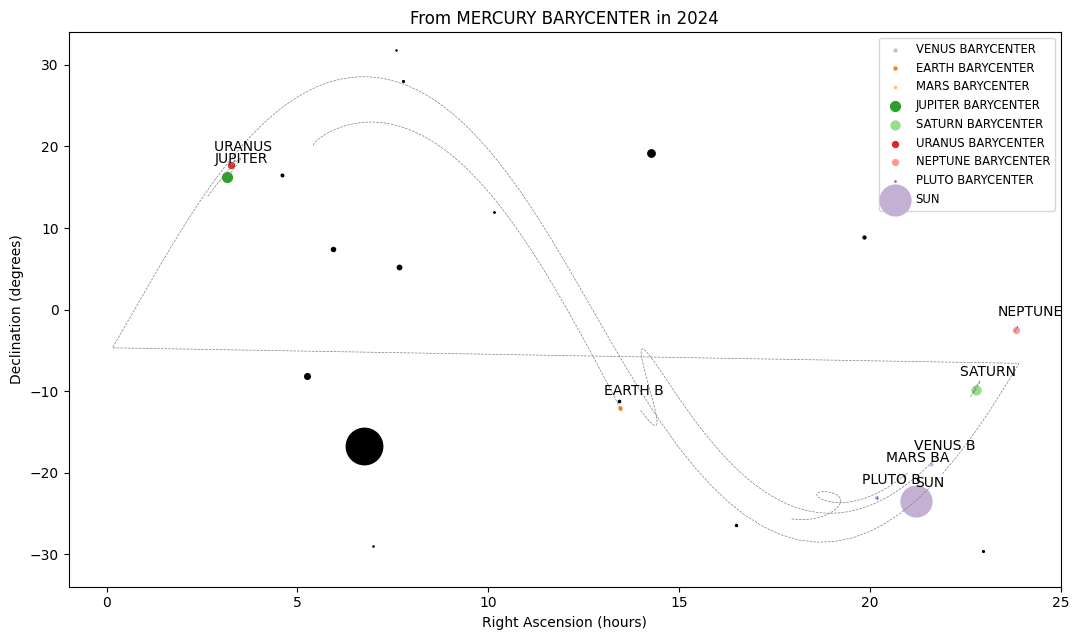

In [6]:
"""This notebook creates a GIF file of the nightsky from the planet Mercury with the 25 brightest stars and the other planets' orbits for the current year."""

"""Install skyfield and matplotlib libraries in notebook to create the nightsky plot."""
%pip install skyfield
%pip install matplotlib

"""Import required libraries and modules."""
from google.colab import files
from skyfield.api import load, Star
from skyfield.data import hipparcos
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation',html='jshtml')
import matplotlib.animation as animation
from datetime import datetime

"""Get the current date and time to create a unique file name for the GIF file."""
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
current_year = datetime.now().strftime("%Y")

"""Convert the datetime object to a string to create a unique file name for the GIF file."""
str_current_datetime = str(current_datetime)

"""Load the Hipparcos star data."""
with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

"""Get the 25 brightest stars from the Hipparcos star data."""
bright_stars = df.sort_values('magnitude').head(25)

"""Load the DE440 planetary ephemeris and create a list of years to plot the nightsky."""
planets = load('de440s.bsp')
years = [int(current_year)]

"""Create a figure object to plot the results."""
fig, ax = plt.subplots(figsize=(12.8,7.2))

"""Create a list of planet names and colors."""
planet_names = ['MERCURY BARYCENTER', 'VENUS BARYCENTER', 'EARTH BARYCENTER', 'MARS BARYCENTER', 'JUPITER BARYCENTER', 'SATURN BARYCENTER', 'URANUS BARYCENTER', 'NEPTUNE BARYCENTER', 'PLUTO BARYCENTER', 'SUN']
planet_colors = matplotlib.colormaps['tab20'].colors[:len(planet_names)]

"""Create a dictionary of the radii of the solar system objects in meters."""
planet_radii = {
    'MERCURY BARYCENTER': 2439.7e3,
    'VENUS BARYCENTER': 6051.8e3,
    'EARTH BARYCENTER': 6371e3,
    'MARS BARYCENTER': 3389.5e3,
    'JUPITER BARYCENTER': 69911e3,
    'SATURN BARYCENTER': 58232e3,
    'URANUS BARYCENTER': 25362e3,
    'NEPTUNE BARYCENTER': 24622e3,
    'PLUTO BARYCENTER': 1188.3e3,
    'SUN': 6.9634e8
    }

"""Create a list of the number of sols per year on each planet."""
sols_per_planet_year = [88, 225, 365, 687, 4333, 10759, 30687, 60190, 90520, 365]

"""Create a timescale object and get the current time."""
ts = load.timescale()
t  = ts.now()

def planets_obs_matrix(planetarg, yeararg):
    """A list of daily observations of the planets in the solar system from a given planet for a given year.

    Args:
        planetarg (int): Planet you are observing from
        yeararg (int): Year you are observing in

    Returns:
        daily_obs (list): The list of daily observations of the planets in the solar system from a given planet for a given year
    """
    daily_obs = []
    days = sols_per_planet_year[planetarg]
    planet_obs_from = planets[planet_names[planetarg]]

    for day in range(1, days + 1):
        t_day = ts.utc(yeararg, 1, day)

        for j in range(len(planet_names)):
            if j != planetarg:
                planet = planets[planet_names[j]]
                observation = planet_obs_from.at(t_day).observe(planet).apparent()
                ra, dec, _ = observation.radec()
                obs_list = [yeararg, day, j, ra.hours, dec.degrees]
                daily_obs.append(obs_list)

    return daily_obs

def plot_orbit(planet_name, years, days_per_year, ax, planet_obs_from, ts):
    """Plot the observed planets' orbital paths

    Args:
        planet_name (string): The name of the planet being observed
        years (int): The years to plot
        days_per_year (int): The number of days in a year on the observer planet
        ax (int): The right ascension and declination of the observed planet
        planet_obs_from (string): The name of the planet the observer is on
        ts (Time): The timescale object from skyfield library
    """
    orbit_points = []

    for year in years:
        for day in range(1, days_per_year + 2):
            t_day = ts.utc(year, 1, day)
            astrometric = planet_obs_from.at(t_day).observe(planets[planet_name])
            ra, dec, _ = astrometric.radec()
            orbit_points.append((ra.hours, dec.degrees))

    # Filter points to avoid drawing stray lines due to wrapping RA values
    filtered_orbit_points = []
    prev_ra = None
    for ra, dec in orbit_points:
        if prev_ra is not None and abs(ra - prev_ra) > 12:  # RA wrapping around 24 hours
            filtered_orbit_points.append((None, None))  # Add a break in the line
        filtered_orbit_points.append((ra, dec))
        prev_ra = ra

    # Plot the filtered orbit points
    filtered_orbit_points = list(zip(*filtered_orbit_points))
    ax.plot(filtered_orbit_points[0], filtered_orbit_points[1], color='gray', linestyle='dashed', linewidth=0.5)
    
def update_plot(frame, all_obs, ax, planet_colors, days, planet_obs_from, planet_observer):
    """Update the plot with the observed planets' positions

    Args:
        frame (int): The frame number
        all_obs (list): The list of all observations
        ax (Axes): The axis object
        planet_colors (string): The colors of the planets
        days (int): The number of days in a year on the observer planet
        planet_obs_from (string): The name of the planet the observer is on
        planet_observer (int): The index of the observer planet
    """
    ax.clear()
    ax.set_ylim(-34, 34)
    ax.set_xlim(-1, 25)
    ax.set_xlabel('Right Ascension (hours)')
    ax.set_ylabel('Declination (degrees)')

    year = all_obs[frame // days][0]
    day = frame % days

    """ List to store planets that have been plotted """
    plotted_planets = []  

    for observation in all_obs:
        if observation[0] == year and observation[1] == day:
            _, _, planet_index, ra, dec = observation
            planet_radius = planet_radii[planet_names[planet_index]]
            """Adjust scale factor based on your preference"""
            scaled_size = 4.5 * (planet_radius / planet_radii['EARTH BARYCENTER']) 
            planet_marker = ax.scatter(ra, dec, s=scaled_size, color=planet_colors[planet_index])
            plotted_planets.append((planet_marker, planet_names[planet_index][:20]))
            ax.annotate(planet_names[planet_index][:7], (ra, dec), textcoords="offset points", xytext=(10, 10), ha='center')

    for planet_name in planet_names:
        plot_orbit(planet_name, years, days, ax, planets[planet_names[planet_observer]], ts)

    """Scael stars based on their magnitudes"""
    for _, star_row in bright_stars.iterrows():
        star = Star.from_dataframe(star_row)
        astrometric = planet_obs_from.at(t).observe(star)
        ra, dec, _ = astrometric.radec()

        """Compute scaling factor based on magnitude of the star"""
        magnitude = star_row['magnitude']
        """Base size for stars (you can adjust this value)"""
        base_size = 25  
        """Inverse proportionality to the magnitude of the star"""
        scaled_size = base_size * 10 ** (-magnitude) 

        ax.scatter(ra.hours, dec.degrees, color='black', s=scaled_size)

    ax.set_title(f'From {planet_names[planet_observer]} in {years[0]}')

    """Create legend for the plotted planets"""
    if plotted_planets:
        markers, labels = zip(*plotted_planets)
        ax.legend(markers, labels, loc='upper right', fontsize='small')

def plot_sky(planet_observer):
    """Plot the nightsky from a given planet with the 25 brightest stars and the other planets' orbits for the given year.

    Args:
        planet_observer (int): Index of the planet you are observing from
    """
    days = sols_per_planet_year[planet_observer]
    planet_name = planet_names[planet_observer]
    planet_obs_from = planets[planet_name]

    """Load the Hipparcos star data."""
    with load.open(hipparcos.URL) as f:
        df = hipparcos.load_dataframe(f)
        df = df[df['magnitude'] <= 3.0]
        """Store the brightest stars from the Hipparcos star data."""
        bright_stars = df 
    all_obs = []
    for year in years:
        daily_obs = planets_obs_matrix(planet_observer, year)
        all_obs.extend(daily_obs)

    """Create the animation object."""
    ani = animation.FuncAnimation(fig, update_plot, frames=range(1, len(years) * days), fargs=(all_obs, ax, planet_colors, days, planet_obs_from, planet_observer), repeat=True, interval=200)

   
    """Generate the GIF file name and save the GIF file to the notebook's Files folder."""
    ani.save(str_current_datetime+'_'+str(planet_names[planet_observer])+'_astroselfie.gif')
    files.download(str_current_datetime +'_'+str(planet_names[planet_observer]) + '_astroselfie.gif')

"""Plot the nightsky from the planet Mercury with the 25 brightest stars and the other planets' orbits for the current year."""
plot_sky(0)
print("Done.")